In [1]:
import matplotlib
import matplotlib.font_manager as fm

matplotlib.use('Agg')
#matplotlib.rc('font', family="D2Coding")
# [f.fname for f in matplotlib.font_manager.fontManager.ttflist]
font_location = 'C:\\Users\\62190\\AppData\\Local\\Microsoft\\Windows\\Fonts\\NanumBarunGothic.ttf' # ex - 또는 ./utils/NanumBarunGothic.ttf
font_name = fm.FontProperties(fname = font_location).get_name()
matplotlib.rc('font', family = font_name)

from patsy import *
# 경고 무시
import warnings
warnings.simplefilter('ignore')

# 자주 사용하는 패키지를 임포트
import matplotlib as mpl
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import numpy as np
import scipy as sp
import pandas as pd
import statsmodels.api as sm
import sklearn as sk
import pgmpy
import scipy.stats

# matplotlib 설정
mpl.use('Agg')

# seaborn 설정
sns.set()
sns.set_style("whitegrid")
sns.set_color_codes()

%matplotlib inline

## 5.1 분류용 예제 데이터

여기에서는 사이킷런 패키지에서 제공하는 분류용 예제 데이터의 일부를 소개한다. 이 데이터들을 살펴보면서 분류 모형에 대한 기초적인 공부를 시작한다.

### 붓꽃 데이터

붓꽃 데이터는 통계학자 피셔(R.A Fisher)의 붓꽃의 분류 연구에 기반한 데이터다. `load_iris()` 명령으로 로드한다. 데이터는 다음과 같이 구성되어 있다.

* 타겟 데이터
  * setosa, versicolor, virginica의 세가지 붓꽃 종(species)

* 특징 데이터
 * 꽃받침 길이(Sepal Length)
 * 꽃받침 폭(Sepal Width)
 * 꽃잎 길이(Petal Length)
 * 꽃잎 폭(Petal Width)

좀 더 자세한 내용은 `load_iris()` 명령으로 로드한 데이터의 `DESCR` 속성으로 알 수 있다.

In [2]:
from sklearn.datasets import load_iris
iris = load_iris()
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

Pandas패키지로 데이터프레임을 만들어 일부 데이터를 살펴본다.

In [3]:
df = pd.DataFrame(iris.data, columns=iris.feature_names)
sy = pd.Series(iris.target, dtype="category")
sy = sy.cat.rename_categories(iris.target_names)
df['species'] = sy
df.tail()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica
149,5.9,3.0,5.1,1.8,virginica


각 특징값의 분포와 상관관계를 히스토그램과 스캐터플롯으로 나타내면 다음과 같다.

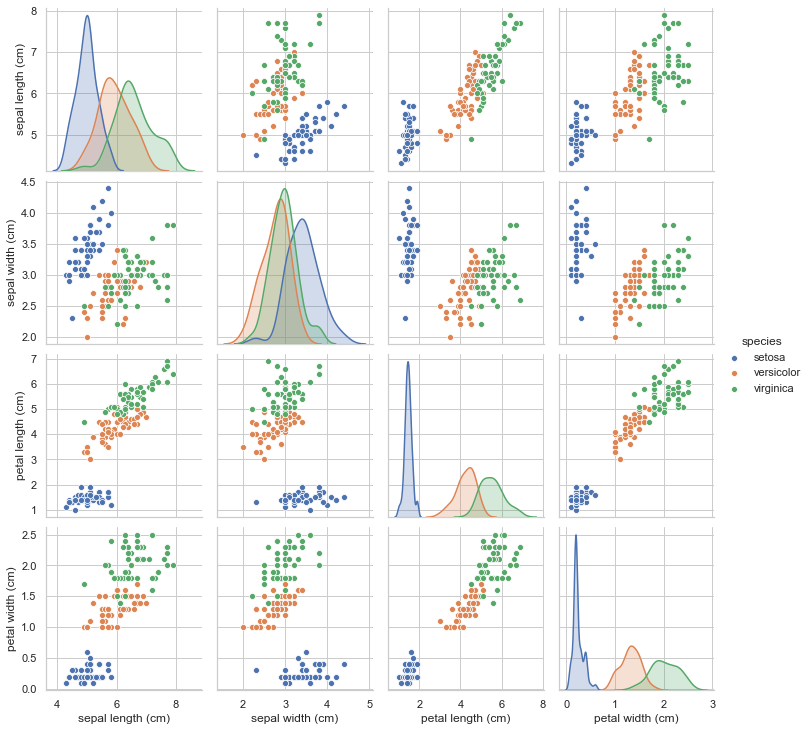

In [4]:
sns.pairplot(df, hue="species")
plt.show()

이 분포를 잘 살펴보면 꽃잎의 길이만으로도 세토사와 다른 종을 분류할 수 있다는 것을 알 수 있다.

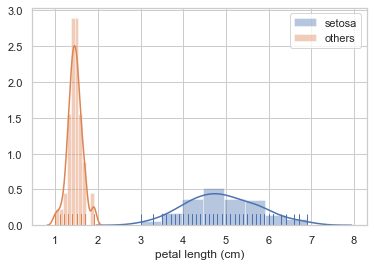

In [5]:
sns.distplot(df[df.species != "setosa"]["petal length (cm)"], hist=True, rug=True, label="setosa")
sns.distplot(df[df.species == "setosa"]["petal length (cm)"], hist=True, rug=True, label="others")
plt.legend()
plt.show()

#### 연습 문제 1

꽃잎 길이의 기준값(thresh)이 얼마이면 세토사와 다른 종을 완벽하게 구분할 수 있는가?

하지만 베르시칼라와 버지니카는 이 방법으로 완벽한 구분이 불가능하다.

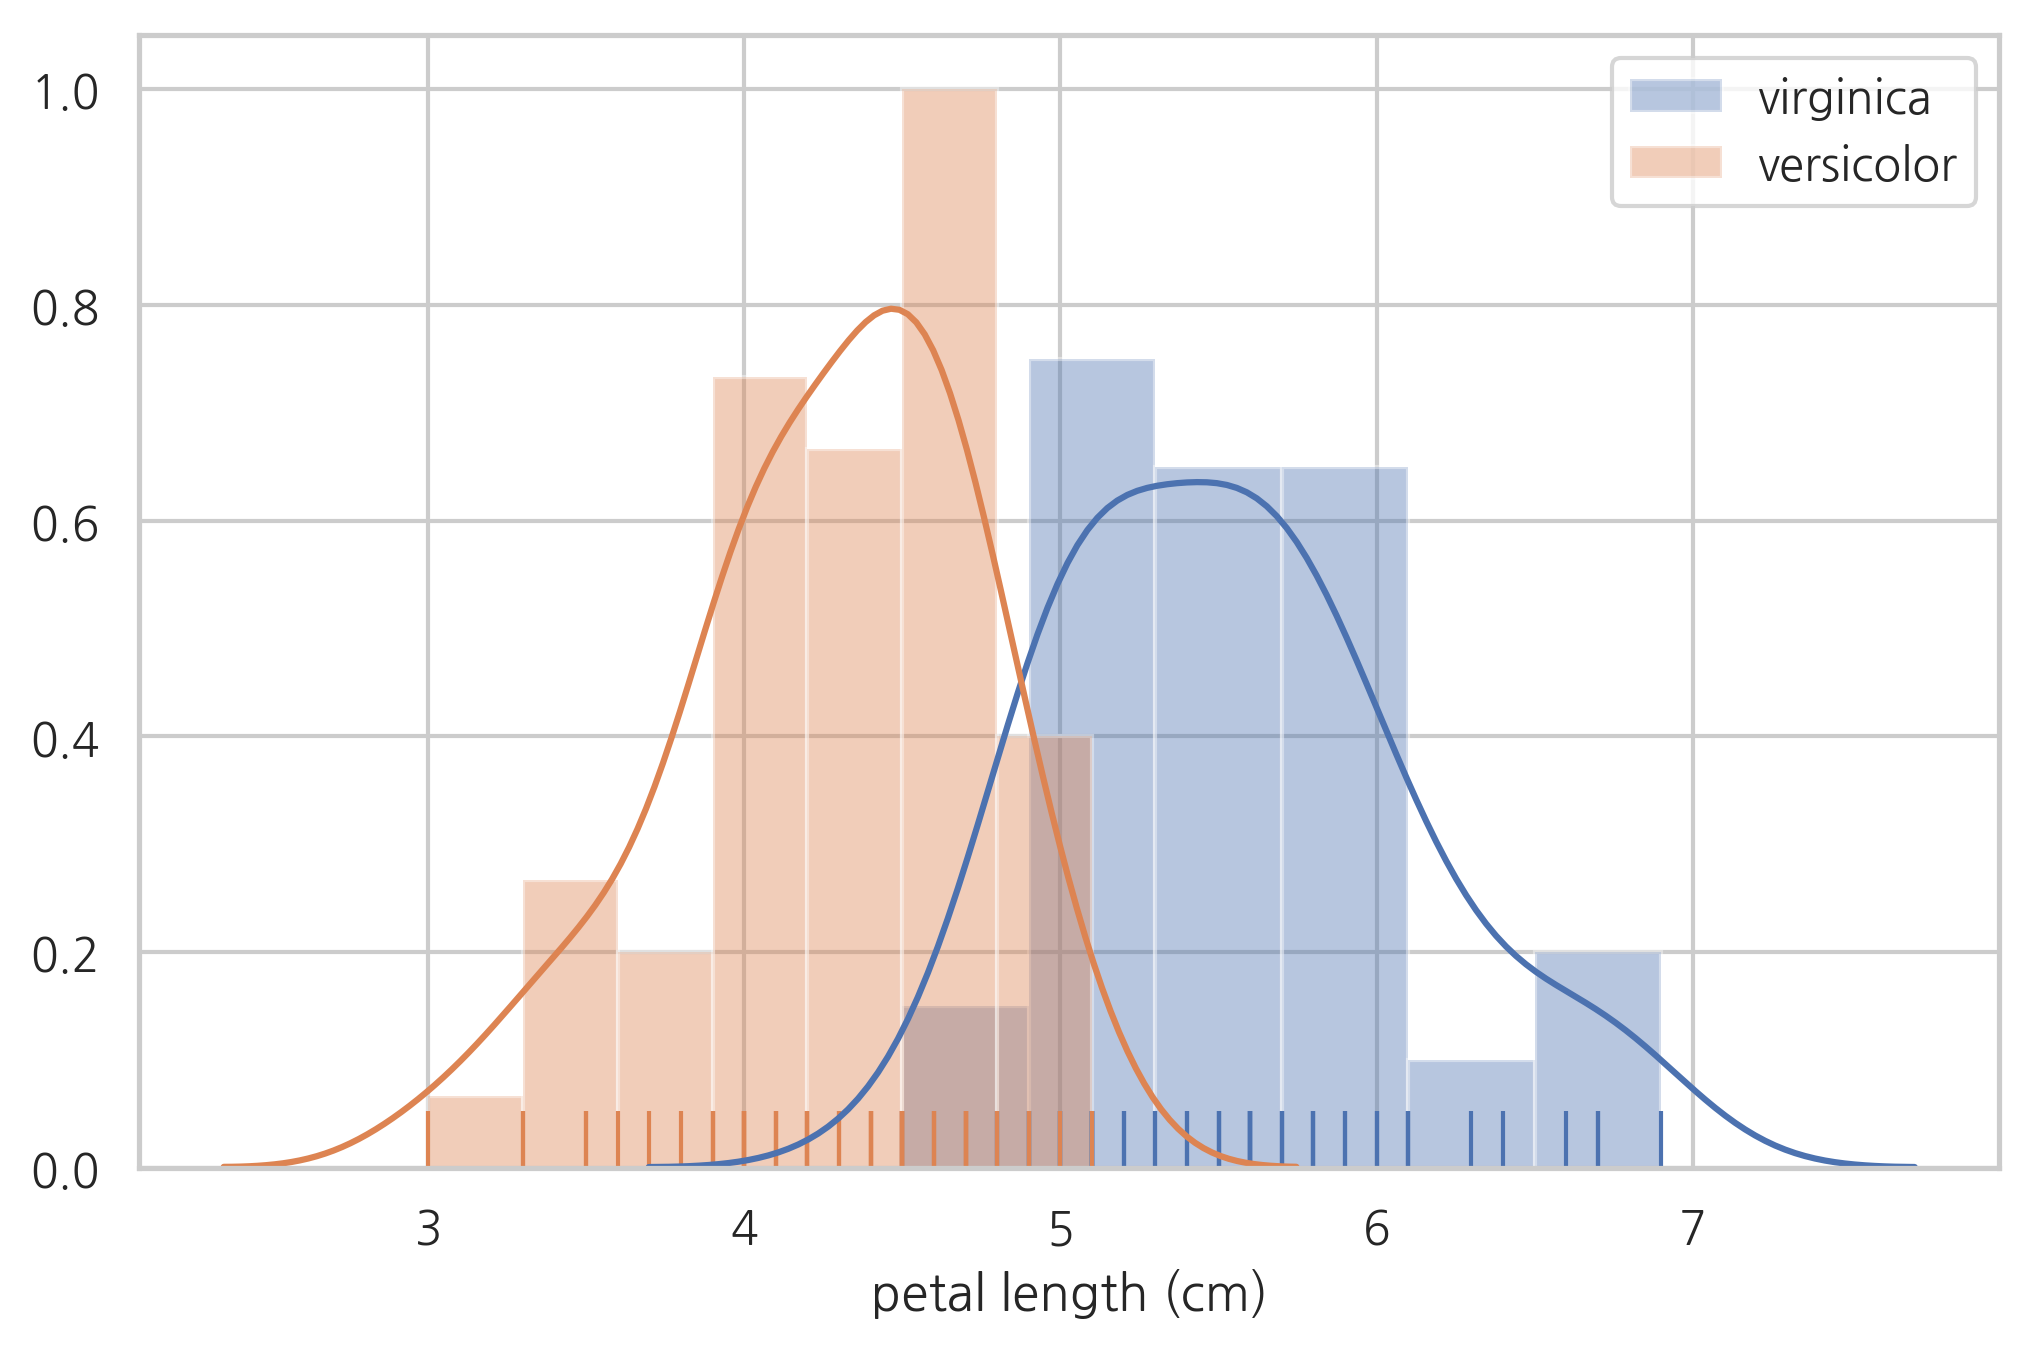

In [5]:
sns.distplot(df[df.species == "virginica"]["petal length (cm)"], hist=True, rug=True, label="virginica")
sns.distplot(df[df.species == "versicolor"]["petal length (cm)"], hist=True, rug=True, label="versicolor")
plt.legend()
plt.show()

#### 연습 문제 2

(1) 가장 적합한 꽃잎 길이의 기준값(thresh)을 생각하고 이 값을 이용하여 베르시칼라와 버지니카를 분류하라.

(2) 위 방법에 따라서 분류하였을 때 잘못 분류된 표본의 갯수는 몇개인가?

In [10]:
threshold = 4.75
df["species2"] = df["species"] == "versicolor"
df["predict"] = df["petal length (cm)"] <= threshold
(df.predict == df.species2).sum()

93

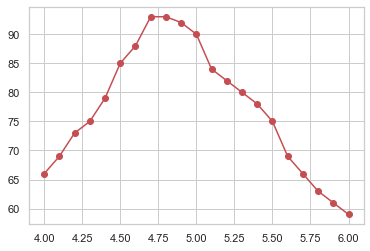

In [17]:
def accuracy(thresholds):
    df["predict"] = df["petal length (cm)"] <= thresholds
    return (df.predict == df.species2).sum()

thresholds = np.linspace(4, 6, 21)
list_accuracy = []
for t in thresholds:
    list_accuracy.append(accuracy(t))

plt.plot(thresholds,list_accuracy, "ro-")

### 와인 데이터

와인의 화학 조성을 사용하여 와인의 종류를 예측하기 위한 데이터이다. `load_wine()` 명령으로 로드하며 다음과 같이 구성되어 있다.

* 타겟 데이터
  * 와인의 종류 0, 1, 2의 세가지 값

* 특징 데이터
 * 알콜(Alcohol)
 * 말산(Malic acid)
 * 회분(Ash)
 * 회분의 알칼리도(Alcalinity of ash) 
 * 마그네슘(Magnesium)
 * 총 폴리페놀(Total phenols)
 * 플라보노이드 폴리페놀(Flavanoids)
 * 비 플라보노이드 폴리페놀(Nonflavanoid phenols)
 * 프로안토시아닌(Proanthocyanins)
 * 색상의 강도(Color intensity)
 * 색상(Hue)
 * 희석 와인의 OD280/OD315 비율 (OD280/OD315 of diluted wines)
 * 프롤린(Proline)


In [18]:
from sklearn.datasets import load_wine
wine = load_wine()
print(wine.DESCR)

.. _wine_dataset:

Wine recognition dataset
------------------------

**Data Set Characteristics:**

    :Number of Instances: 178 (50 in each of three classes)
    :Number of Attributes: 13 numeric, predictive attributes and the class
    :Attribute Information:
 		- Alcohol
 		- Malic acid
 		- Ash
		- Alcalinity of ash  
 		- Magnesium
		- Total phenols
 		- Flavanoids
 		- Nonflavanoid phenols
 		- Proanthocyanins
		- Color intensity
 		- Hue
 		- OD280/OD315 of diluted wines
 		- Proline

    - class:
            - class_0
            - class_1
            - class_2
		
    :Summary Statistics:
    
    ============================= ==== ===== ======= =====
                                   Min   Max   Mean     SD
    ============================= ==== ===== ======= =====
    Alcohol:                      11.0  14.8    13.0   0.8
    Malic Acid:                   0.74  5.80    2.34  1.12
    Ash:                          1.36  3.23    2.36  0.27
    Alcalinity of Ash:            1

In [19]:
df = pd.DataFrame(wine.data, columns=wine.feature_names)
sy = pd.Series(wine.target, dtype="category")
sy = sy.cat.rename_categories(wine.target_names)
df['class'] = sy
df.tail()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,class
173,13.71,5.65,2.45,20.5,95.0,1.68,0.61,0.52,1.06,7.7,0.64,1.74,740.0,class_2
174,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.3,0.70,1.56,750.0,class_2
175,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.2,0.59,1.56,835.0,class_2
176,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.3,0.60,1.62,840.0,class_2
177,14.13,4.10,2.74,24.5,96.0,2.05,0.76,0.56,1.35,9.2,0.61,1.60,560.0,class_2


일부 특징값의 분포와 상관관계를 히스토그램과 스캐터플롯으로 나타내면 다음과 같다.

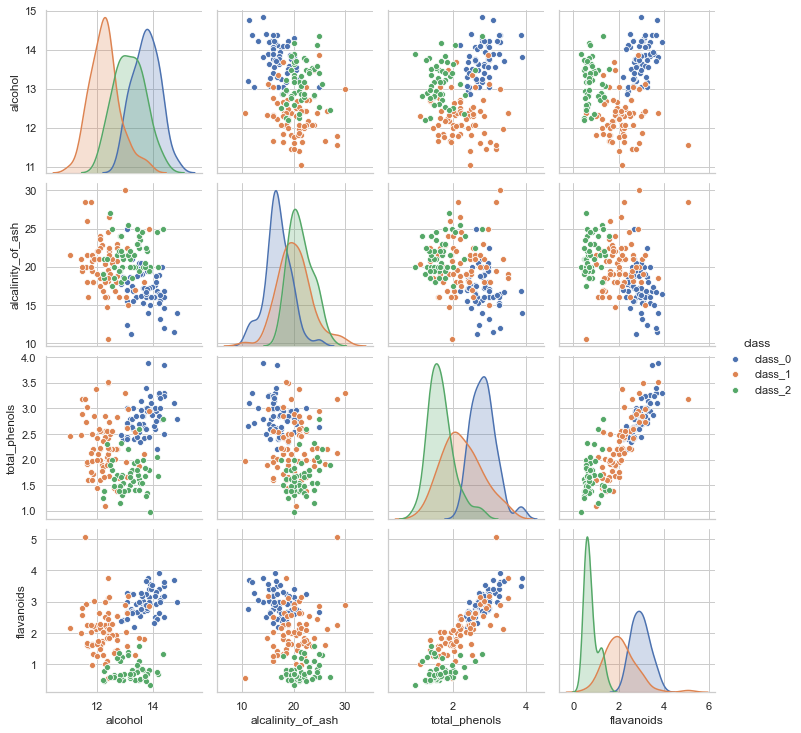

In [20]:
sns.pairplot(vars=["alcohol", "alcalinity_of_ash", "total_phenols", "flavanoids"], 
             hue="class", data=df)
plt.show()

#### 연습 문제 3

위 시각화 결과에서 어떤 특징값을 사용하면 두 개의 클래스를 완벽하게 구분할 수 있다는 것을 알 수 있다. 어떤 특징값이고 어떤 클래스를 구분할 수 있는가?

### 유방암 진단 데이터

`load_breast_cancer` 명령은 유방암(breast cancer) 진단 데이터를 제공한다. 유방암 진단 사진으로부터 측정한 종양(tumar)의 특징값을 사용하여 종양이 양성(benign)인지 악성(malignant)인지를 판별한다.

In [21]:
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()
print(cancer.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry 
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 3 is Mean Radius, f

In [22]:
df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
sy = pd.Series(cancer.target, dtype="category")
sy = sy.cat.rename_categories(cancer.target_names)
df['class'] = sy
df.tail()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,class
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,malignant
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,malignant
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,malignant
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,malignant
568,7.76,24.54,47.92,181.0,0.05263,0.04362,0.00000,0.00000,0.1587,0.05884,...,30.37,59.16,268.6,0.08996,0.06444,0.0000,0.0000,0.2871,0.07039,benign


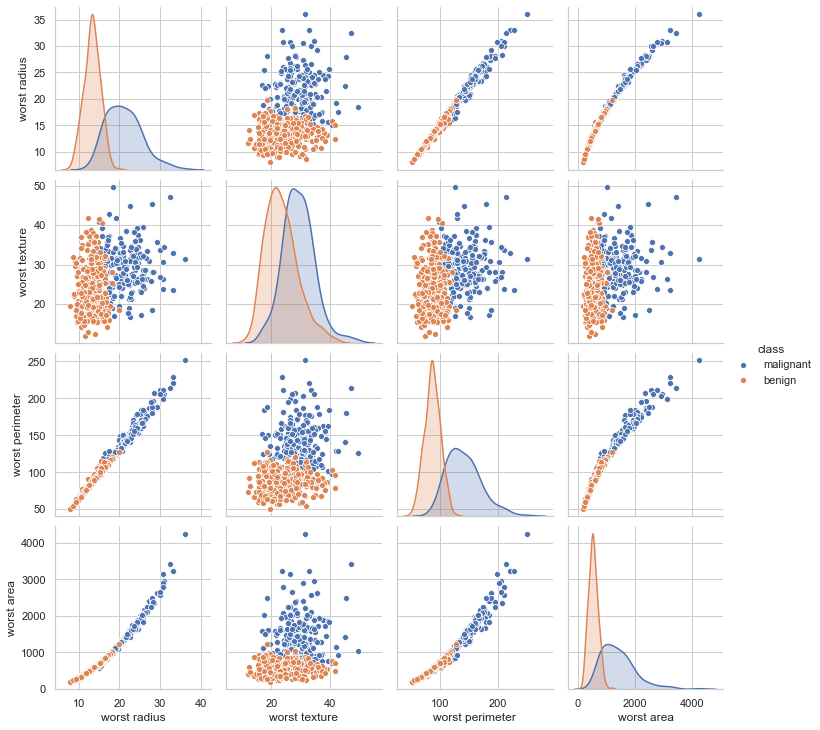

In [23]:
sns.pairplot(vars=["worst radius", "worst texture", "worst perimeter", "worst area"], 
             hue="class", data=df)
plt.show()

### 대표 수종 데이터

대표 수종 데이터는 미국 삼림을 30×30m 영역으로 나누어 각 영역의 특징으로부터 대표적인 나무의 종류(species of tree)을 예측하기위한 데이터이다. 수종은  7종류이지만 특징 데이터가 54종류, 표본 데이터의 갯수가 581,012개에 달하는 대규모 데이터이다.

In [25]:
from sklearn.datasets import fetch_covtype
covtype = fetch_covtype()
print(covtype.DESCR)

KeyError: 0

In [26]:
df = pd.DataFrame(covtype.data, 
                  columns=["x{:02d}".format(i + 1) for i in range(covtype.data.shape[1])],
                  dtype=int)
sy = pd.Series(covtype.target, dtype="category")
df['covtype'] = sy
df.tail()

NameError: name 'covtype' is not defined

각 특징 데이터가 가지는 값의 종류를 보면 1번부터 10번 특징은 실수값이고 11번부터 54번 특징은 이진 카테고리값이라는 것을 알 수 있다.

In [14]:
pd.DataFrame(df.nunique()).T

,x01,x02,x03,x04,x05,x06,x07,x08,x09,x10,...,x46,x47,x48,x49,x50,x51,x52,x53,x54,covtype
0,1978,361,67,551,700,5785,207,185,255,5827,...,2,2,2,2,2,2,2,2,2,7


따라서 이 값을 카테고리 형태로 바꾼다.

In [15]:
df.iloc[:, 10:54] = df.iloc[:, 10:54].astype('category')

다음 플롯은 카테고리값에 따라 "x14" 특징의 값이 어떻게 변하는지 나타낸 것이다. "x14" 특징이 0인가 1인가를 사용하면 1, 5, 7번 클래스와 4번 클래스는 완벽하게 분류할 수 있다는 것을 알 수 있다.

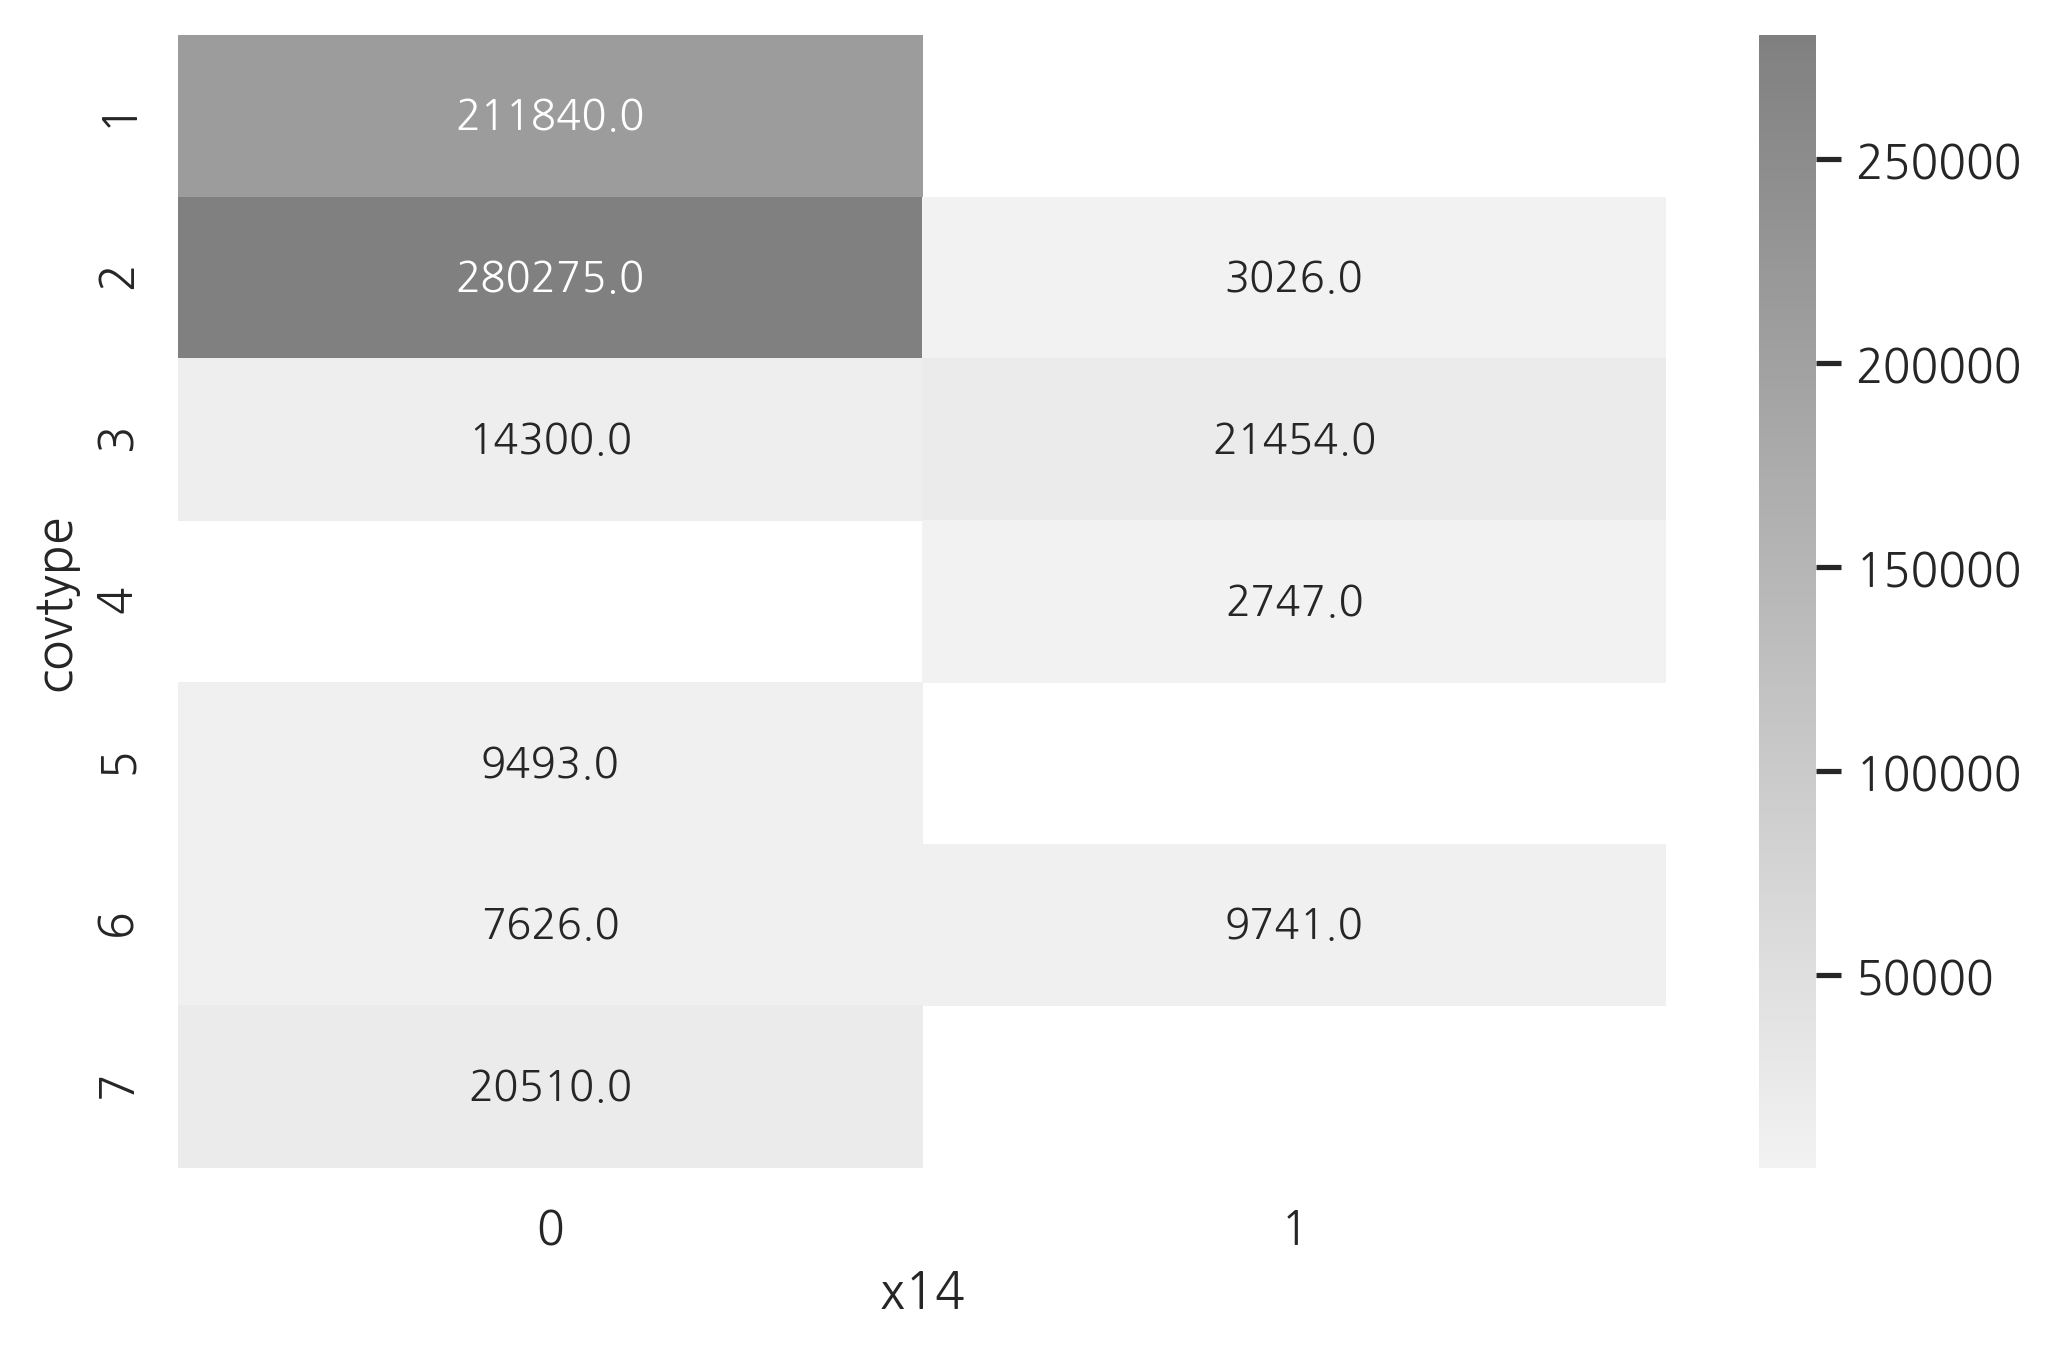

In [16]:
df_count = df.pivot_table(index="covtype", columns="x14", aggfunc="size")
sns.heatmap(df_count, cmap=sns.light_palette("gray", as_cmap=True), annot=True, fmt="0")
plt.show()

### 뉴스 그룹 텍스트 데이터

20개의 뉴스 그룹 문서 데이터. `fetch_20newsgroups()` 명령으로 로드하며 다음과 같이 구성되어 있다.

* 타겟 데이터
  * 문서가 속한 뉴스 그룹

* 특징 데이터
  * 문서 텍스트

In [17]:
from sklearn.datasets import fetch_20newsgroups
newsgroups = fetch_20newsgroups(subset='all')
print(newsgroups.DESCR)

.. _20newsgroups_dataset:

The 20 newsgroups text dataset
------------------------------

The 20 newsgroups dataset comprises around 18000 newsgroups posts on
20 topics split in two subsets: one for training (or development)
and the other one for testing (or for performance evaluation). The split
between the train and test set is based upon a messages posted before
and after a specific date.

This module contains two loaders. The first one,
:func:`sklearn.datasets.fetch_20newsgroups`,
returns a list of the raw texts that can be fed to text feature
extractors such as :class:`sklearn.feature_extraction.text.CountVectorizer`
with custom parameters so as to extract feature vectors.
The second one, :func:`sklearn.datasets.fetch_20newsgroups_vectorized`,
returns ready-to-use features, i.e., it is not necessary to use a feature
extractor.

**Data Set Characteristics:**

    =================   ==========
    Classes                     20
    Samples total            18846
    Dimensionality 

In [18]:
from pprint import pprint
pprint(list(newsgroups.target_names))

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']


In [19]:
print(newsgroups.data[1])
print("=" * 80)
print(newsgroups.target_names[newsgroups.target[1]])

From: mblawson@midway.ecn.uoknor.edu (Matthew B Lawson)
Subject: Which high-performance VLB video card?
Summary: Seek recommendations for VLB video card
Nntp-Posting-Host: midway.ecn.uoknor.edu
Organization: Engineering Computer Network, University of Oklahoma, Norman, OK, USA
Keywords: orchid, stealth, vlb
Lines: 21

  My brother is in the market for a high-performance video card that supports
VESA local bus with 1-2MB RAM.  Does anyone have suggestions/ideas on:

  - Diamond Stealth Pro Local Bus

  - Orchid Farenheit 1280

  - ATI Graphics Ultra Pro

  - Any other high-performance VLB card


Please post or email.  Thank you!

  - Matt

-- 
    |  Matthew B. Lawson <------------> (mblawson@essex.ecn.uoknor.edu)  |   
  --+-- "Now I, Nebuchadnezzar, praise and exalt and glorify the King  --+-- 
    |   of heaven, because everything he does is right and all his ways  |   
    |   are just." - Nebuchadnezzar, king of Babylon, 562 B.C.           |   

comp.sys.ibm.pc.hardware


### 로이터 말뭉치

로이터 말뭉치 데이터는 47,236개의 단어(vocalbulary)로 이루어진 804,414개의 문서를 103개의 클래스로 분류하기 위한 텍스트 데이터이다. TF-IDF 인코딩된 특징 데이터 행렬을 제공한다.

`fetch_rcv1` 명령으로 다운로드 받을 수 있다. 용량때문에 다운로드 시간이 오래 걸릴 수 있다.

In [20]:
from sklearn.datasets import fetch_rcv1
rcv = fetch_rcv1()
print(rcv.DESCR)

.. _rcv1_dataset:

RCV1 dataset
------------

Reuters Corpus Volume I (RCV1) is an archive of over 800,000 manually 
categorized newswire stories made available by Reuters, Ltd. for research 
purposes. The dataset is extensively described in [1]_.

**Data Set Characteristics:**

    ==============     =====================
    Classes                              103
    Samples total                     804414
    Dimensionality                     47236
    Features           real, between 0 and 1
    ==============     =====================

:func:`sklearn.datasets.fetch_rcv1` will load the following 
version: RCV1-v2, vectors, full sets, topics multilabels::

    >>> from sklearn.datasets import fetch_rcv1
    >>> rcv1 = fetch_rcv1()

It returns a dictionary-like object, with the following attributes:

``data``:
The feature matrix is a scipy CSR sparse matrix, with 804414 samples and
47236 features. Non-zero values contains cosine-normalized, log TF-IDF vectors.
A nearly chronologi

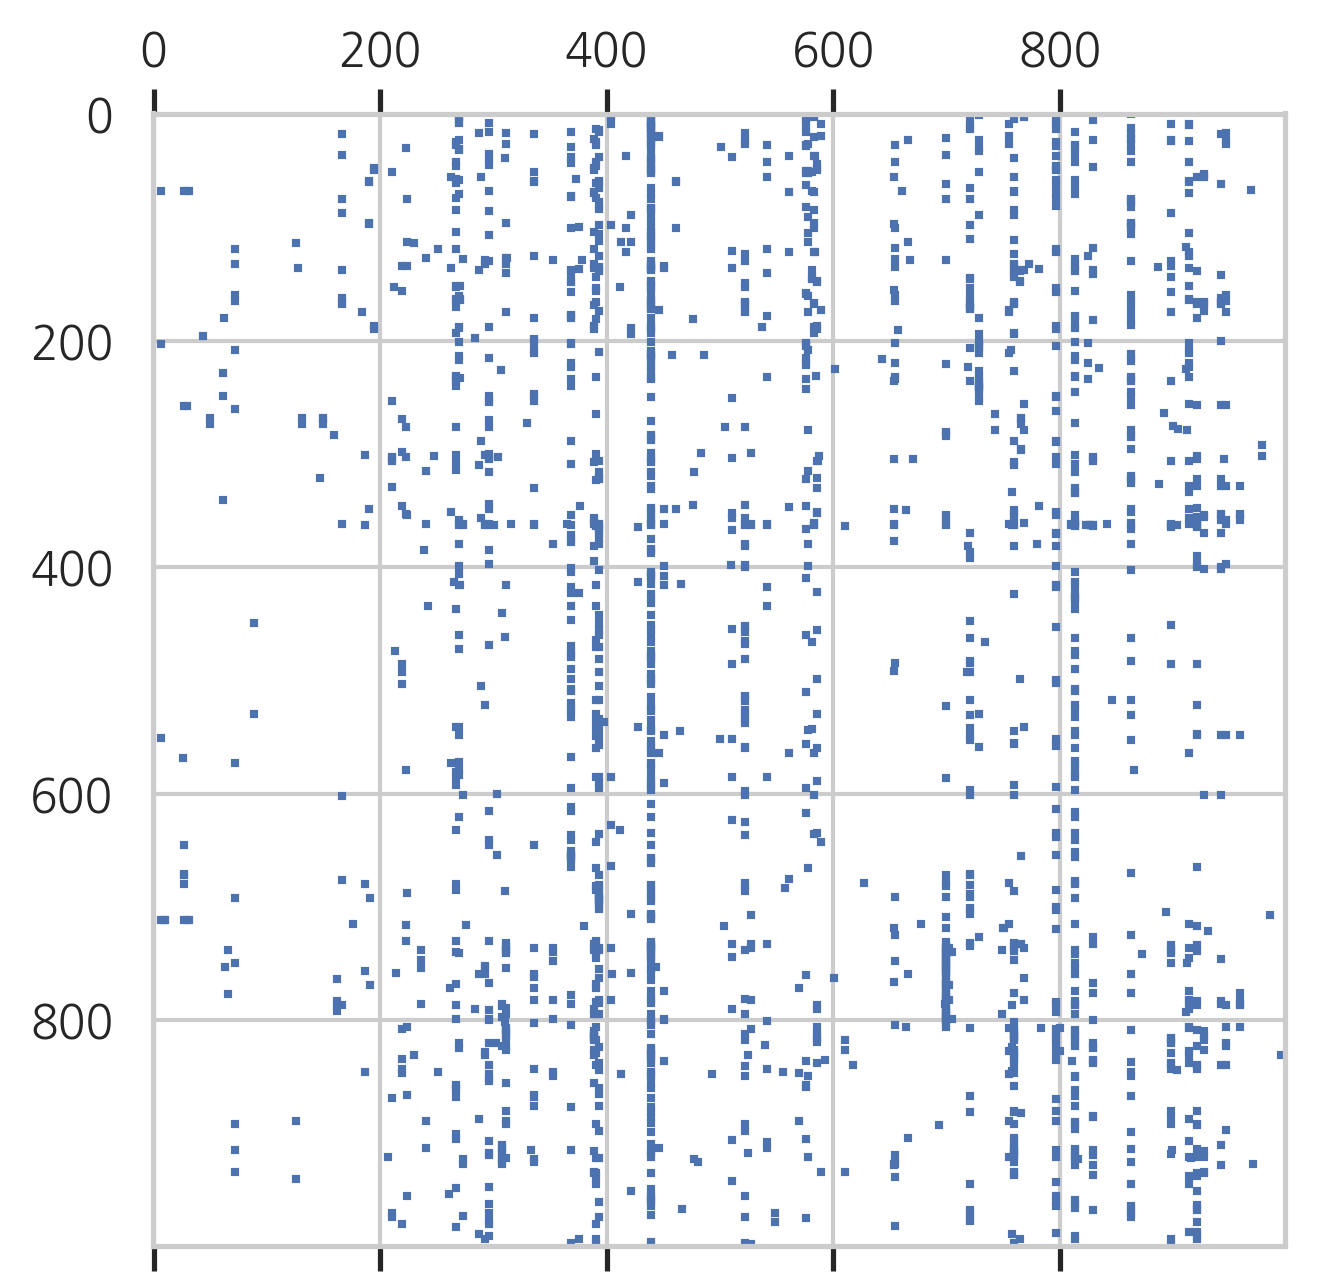

In [21]:
plt.spy(rcv.data[:1000, :1000], markersize=1)
plt.show()

### 숫자 필기 이미지 데이터

0부터 9까지의 숫자를 손으로 쓴 이미지 데이터. `load_digits()` 명령으로 로드한다. 각 이미지는 0부터 15까지의 명암을 가지는 8x8=64픽셀 해상도의 흑백 이미지이다.


In [22]:
from sklearn.datasets import load_digits
digits = load_digits()
print(digits.DESCR)

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 5620
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
http://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each bloc

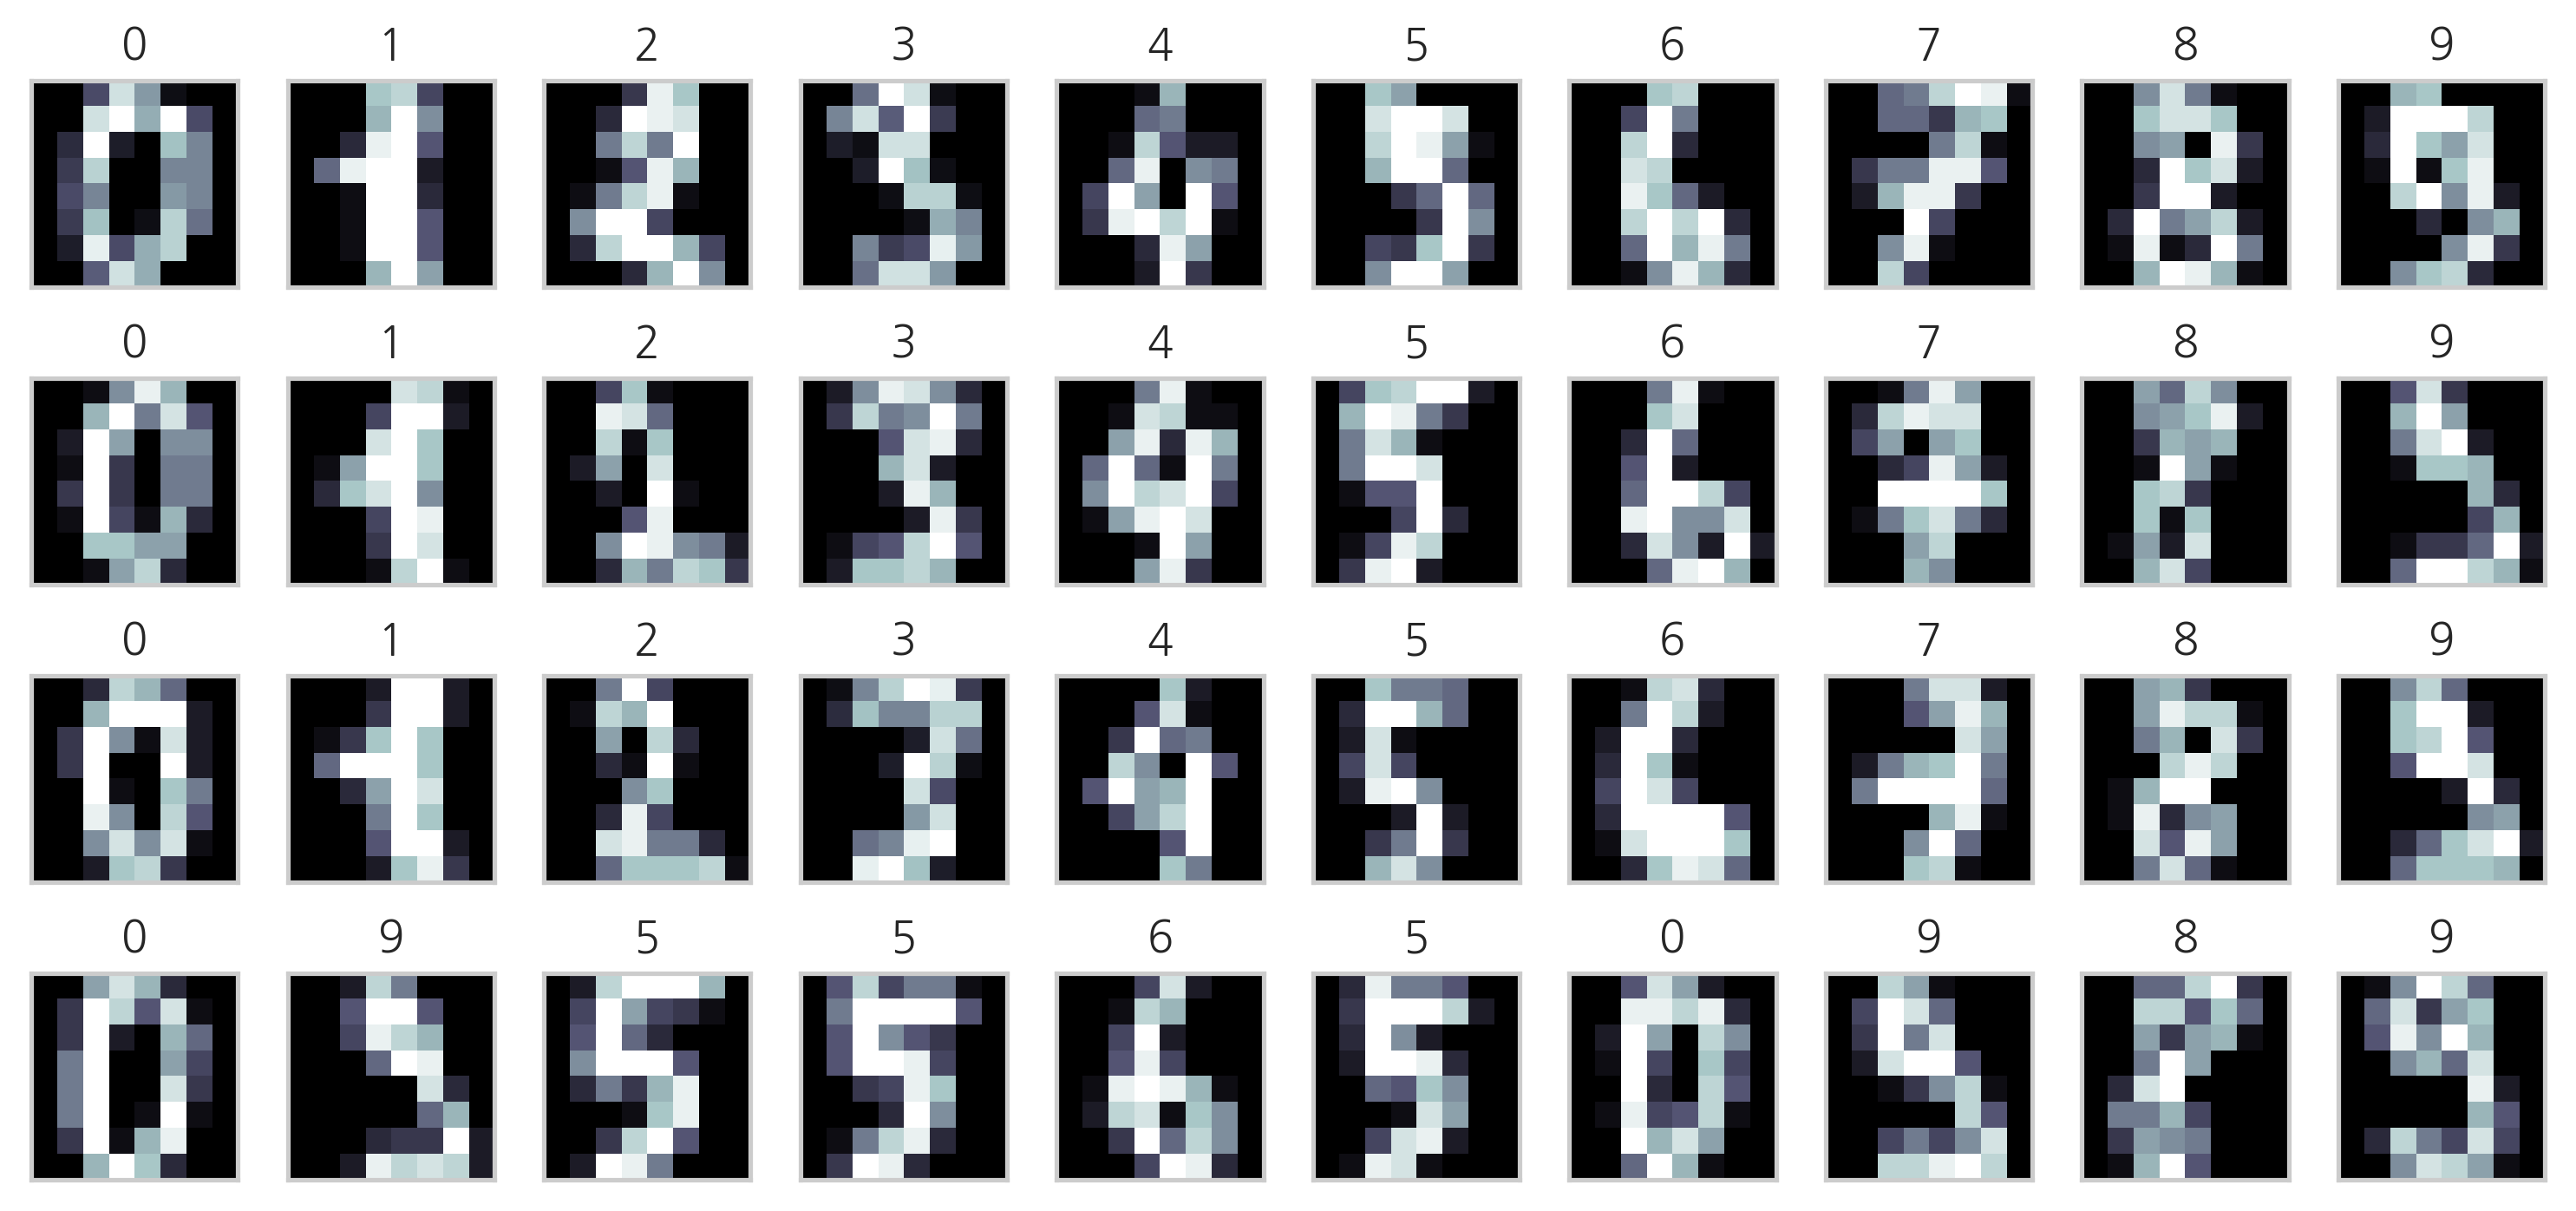

In [23]:
np.random.seed(0)
N = 4
M = 10
fig = plt.figure(figsize=(10, 5))
plt.subplots_adjust(top=1, bottom=0, hspace=0, wspace=0.05)
for i in range(N):
    for j in range(M):
        k = i*M+j
        ax = fig.add_subplot(N, M, k+1)
        ax.imshow(digits.images[k], cmap=plt.cm.bone, interpolation="none")
        ax.grid(False)
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])
        plt.title(digits.target_names[digits.target[k]])
plt.tight_layout()
plt.show()

### 올리베티 얼굴 사진 데이터

AT&T와 캠프리지 대학 전산 연구실에서 공동으로 제작한 얼굴 사진 데이터 베이스의 간략화된 버전. `fetch_olivetti_faces()` 명령으로 로드하며 다음과 같이 구성되어 있다. 64x64=4096 해상도의 흑백 이미지이고 40명의 사진 400장으로 구성되어 있다.

* 타겟 데이터
   * 40명의 개인을 나타내는 식별 번호

* 특징 데이터
  * 각 개인의 얼굴 이미지

In [24]:
from sklearn.datasets import fetch_olivetti_faces
olivetti = fetch_olivetti_faces()
print(olivetti.DESCR)

.. _olivetti_faces_dataset:

The Olivetti faces dataset
--------------------------

`This dataset contains a set of face images`_ taken between April 1992 and 
April 1994 at AT&T Laboratories Cambridge. The
:func:`sklearn.datasets.fetch_olivetti_faces` function is the data
fetching / caching function that downloads the data
archive from AT&T.

.. _This dataset contains a set of face images: http://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html

As described on the original website:

    There are ten different images of each of 40 distinct subjects. For some
    subjects, the images were taken at different times, varying the lighting,
    facial expressions (open / closed eyes, smiling / not smiling) and facial
    details (glasses / no glasses). All the images were taken against a dark
    homogeneous background with the subjects in an upright, frontal position 
    (with tolerance for some side movement).

**Data Set Characteristics:**

    =================   ===========

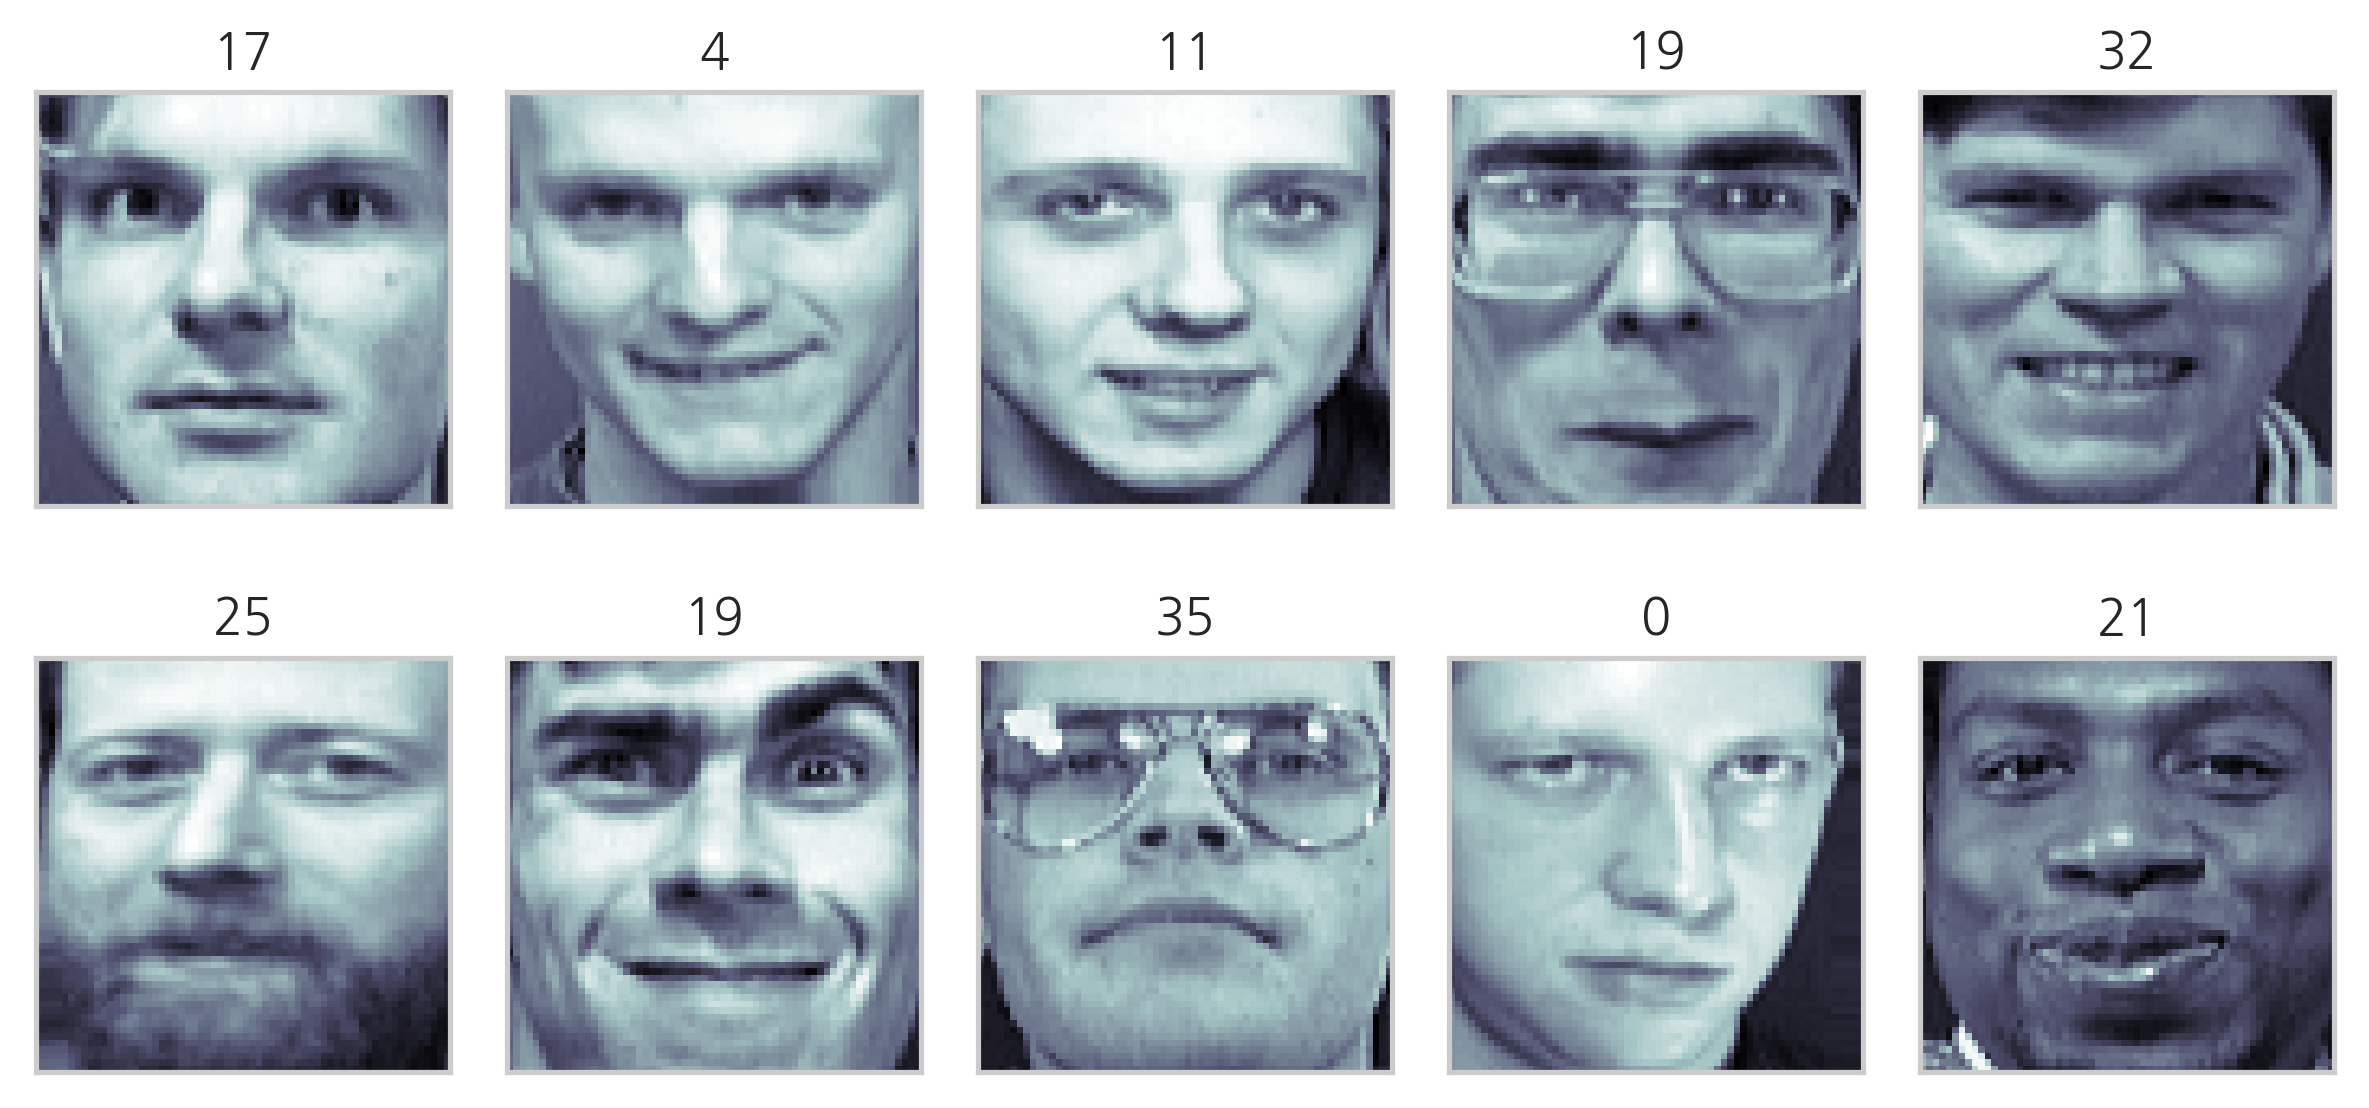

In [25]:
np.random.seed(0)
N = 2
M = 5
fig = plt.figure(figsize=(8, 5))
plt.subplots_adjust(top=1, bottom=0, hspace=0, wspace=0.05)
klist = np.random.choice(range(len(olivetti.data)), N * M)
for i in range(N):
    for j in range(M):
        k = klist[i*M+j]
        ax = fig.add_subplot(N, M, i*M+j+1)
        ax.imshow(olivetti.images[k], cmap=plt.cm.bone)
        ax.grid(False)
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])
        plt.title(olivetti.target[k])
plt.tight_layout()
plt.show()

### Labeled Faces in the Wild (LFW) 데이터

유명 정치인 등의 실제 얼굴에 대한 이미지 데이터. `fetch_lfw_people()` 명령으로 로드한다. 해상도는 50x37=5,828픽셀이고 각 채널이 0~255의 정수값을 가지는 컬러 이미지이다. 5,749명의 13,233개 사진을 가지고 있다. 다음 인수를 사용하여 로드하는 데이터의 양과 종류를 결정할 수 있다.
 
 * `funneled` : 디폴트 `True`
   * 이미지의 위치 조정(funnel) 여부
 * `resize` : 디폴트 0.5
   * 원래 이미지보다 일정 비율로 크기를 줄여서 로드
 * `min_faces_per_person` : 디폴트 None
   * 각 인물당 최소 사진의 수
 * `color` : 디폴트 `False`
   * `True`인 경우에는 컬러 사진을, `False`인 경우에는 흑백 사진을 로드한다.


In [26]:
from sklearn.datasets import fetch_lfw_people
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
print(lfw_people.DESCR)

.. _labeled_faces_in_the_wild_dataset:

The Labeled Faces in the Wild face recognition dataset
------------------------------------------------------

This dataset is a collection of JPEG pictures of famous people collected
over the internet, all details are available on the official website:

    http://vis-www.cs.umass.edu/lfw/

Each picture is centered on a single face. The typical task is called
Face Verification: given a pair of two pictures, a binary classifier
must predict whether the two images are from the same person.

An alternative task, Face Recognition or Face Identification is:
given the picture of the face of an unknown person, identify the name
of the person by referring to a gallery of previously seen pictures of
identified persons.

Both Face Verification and Face Recognition are tasks that are typically
performed on the output of a model trained to perform Face Detection. The
most popular model for Face Detection is called Viola-Jones and is
implemented in the OpenC

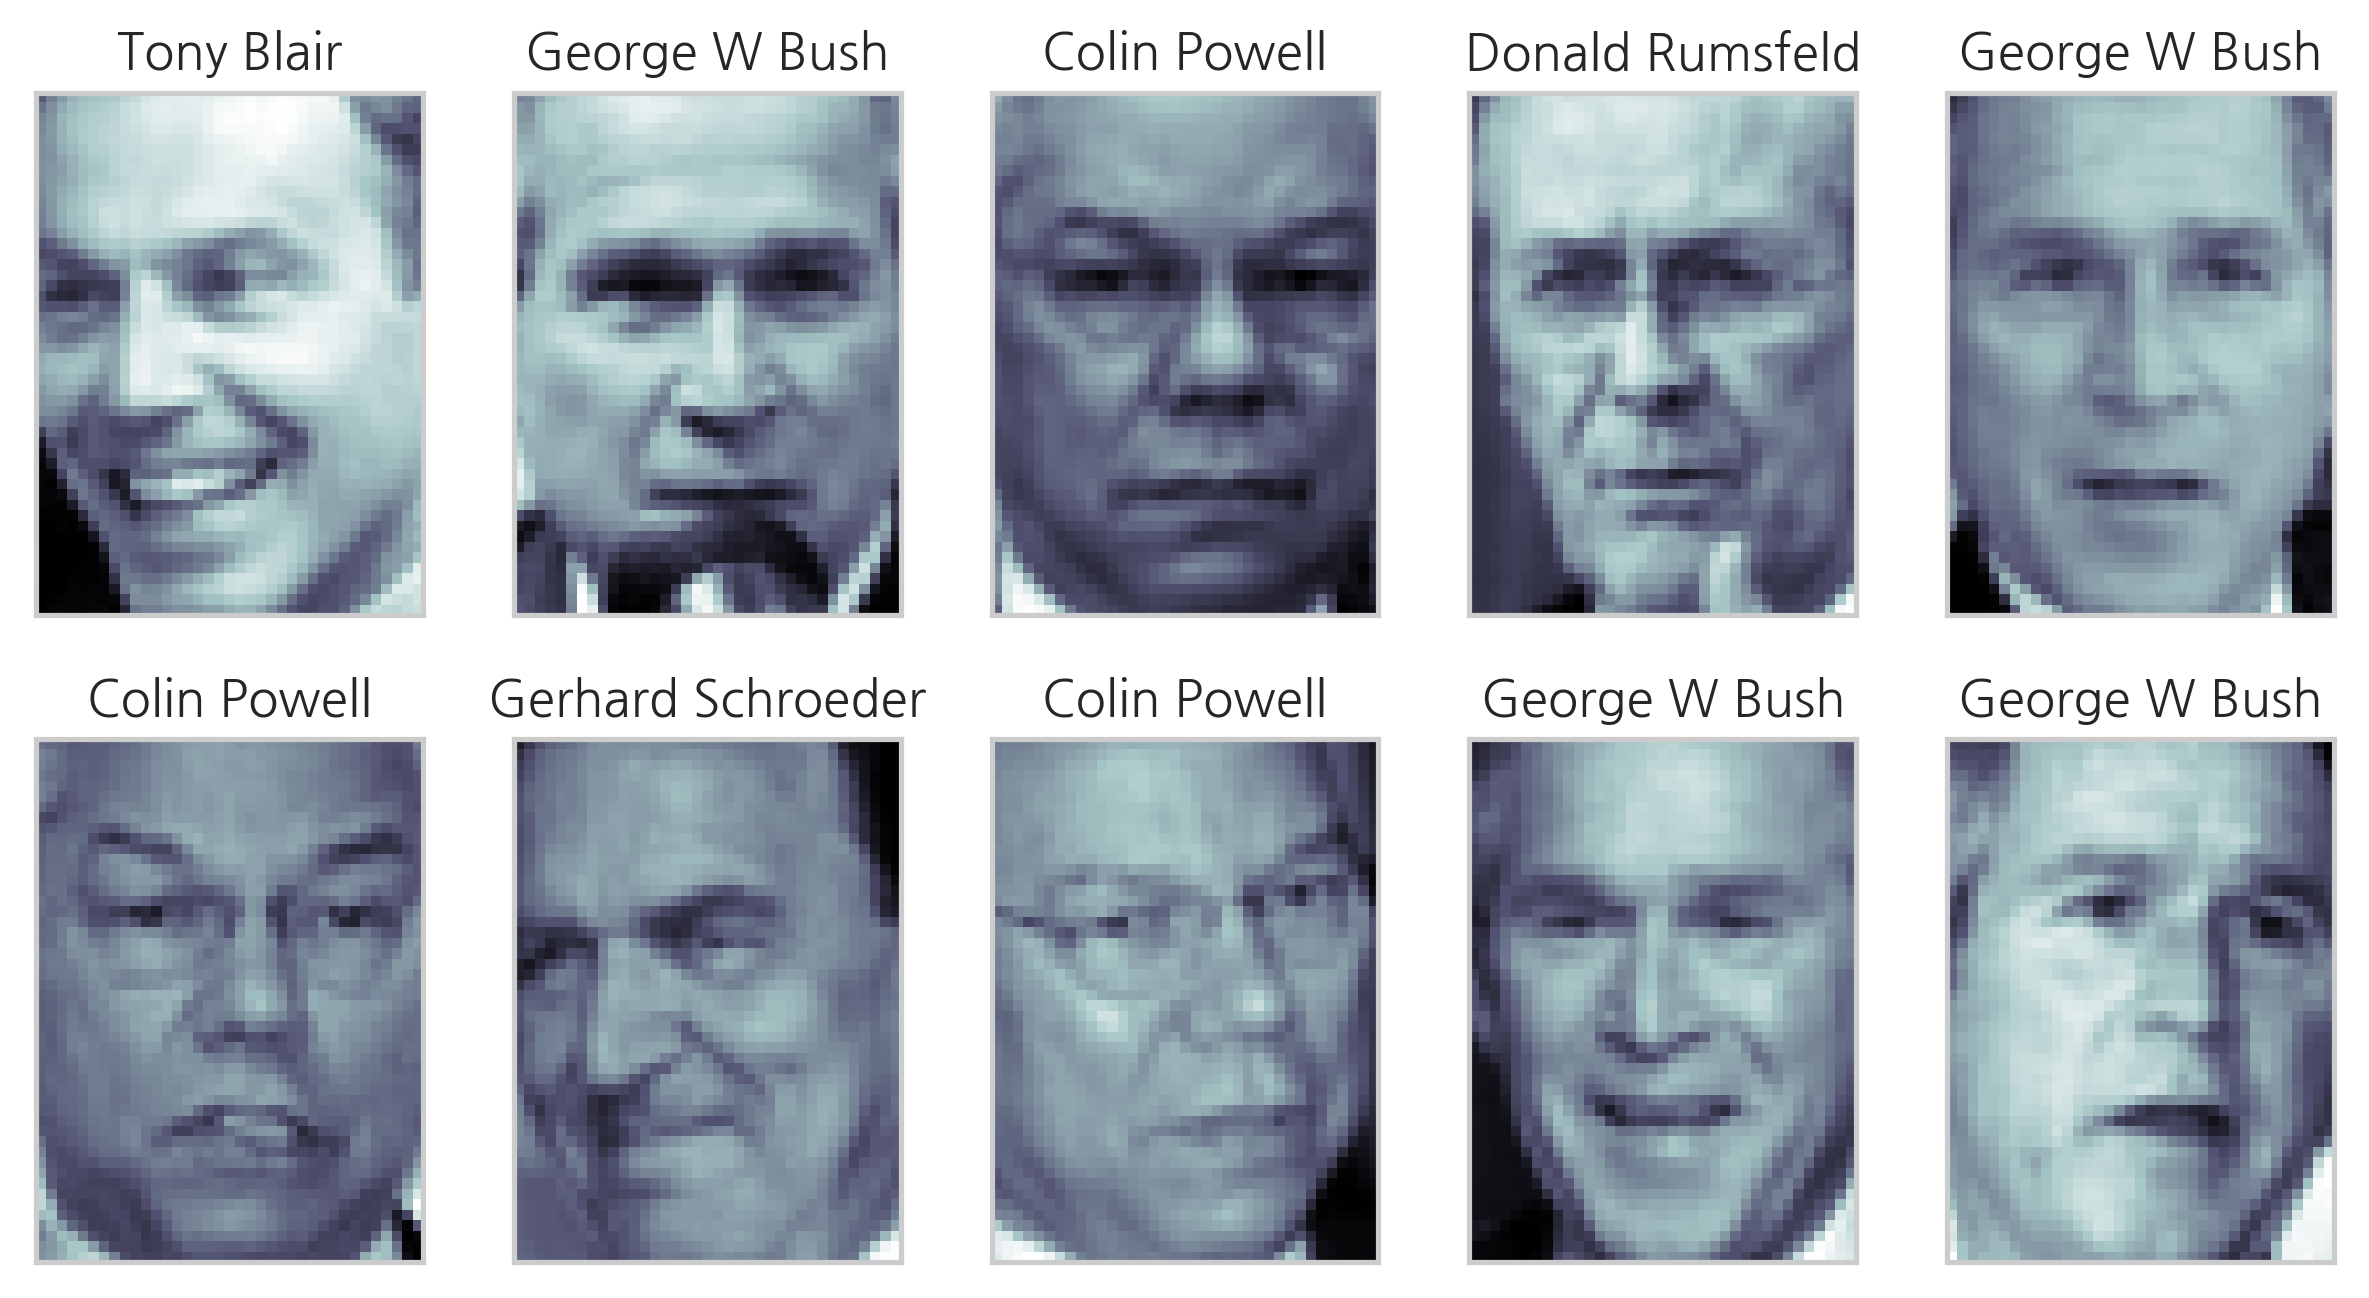

In [27]:
np.random.seed(0)
N = 2
M = 5
fig = plt.figure(figsize=(8, 5))
plt.subplots_adjust(top=1, bottom=0, hspace=0.1, wspace=0.05)
klist = np.random.choice(range(len(lfw_people.data)), N * M)
for i in range(N):
    for j in range(M):
        k = klist[i*M+j]
        ax = fig.add_subplot(N, M, i*M+j+1)
        ax.imshow(lfw_people.images[k], cmap=plt.cm.bone)
        ax.grid(False)
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])
        plt.title(lfw_people.target_names[lfw_people.target[k]])
plt.tight_layout()
plt.show()

 `fetch_lfw_pairs()` 명령을 사용하면 라벨이 아니라 한 쌍의 이미지 데이터를 로드하며 이 한 쌍의 사진은  동일 인물일 수도 있고 아닐 수도 있다. 타겟 데이터는 동일인인지 아닌지를 알려준다.

In [28]:
from sklearn.datasets import fetch_lfw_pairs
lfw_pairs = fetch_lfw_pairs(resize=0.4)
print(lfw_pairs.DESCR)

.. _labeled_faces_in_the_wild_dataset:

The Labeled Faces in the Wild face recognition dataset
------------------------------------------------------

This dataset is a collection of JPEG pictures of famous people collected
over the internet, all details are available on the official website:

    http://vis-www.cs.umass.edu/lfw/

Each picture is centered on a single face. The typical task is called
Face Verification: given a pair of two pictures, a binary classifier
must predict whether the two images are from the same person.

An alternative task, Face Recognition or Face Identification is:
given the picture of the face of an unknown person, identify the name
of the person by referring to a gallery of previously seen pictures of
identified persons.

Both Face Verification and Face Recognition are tasks that are typically
performed on the output of a model trained to perform Face Detection. The
most popular model for Face Detection is called Viola-Jones and is
implemented in the OpenC

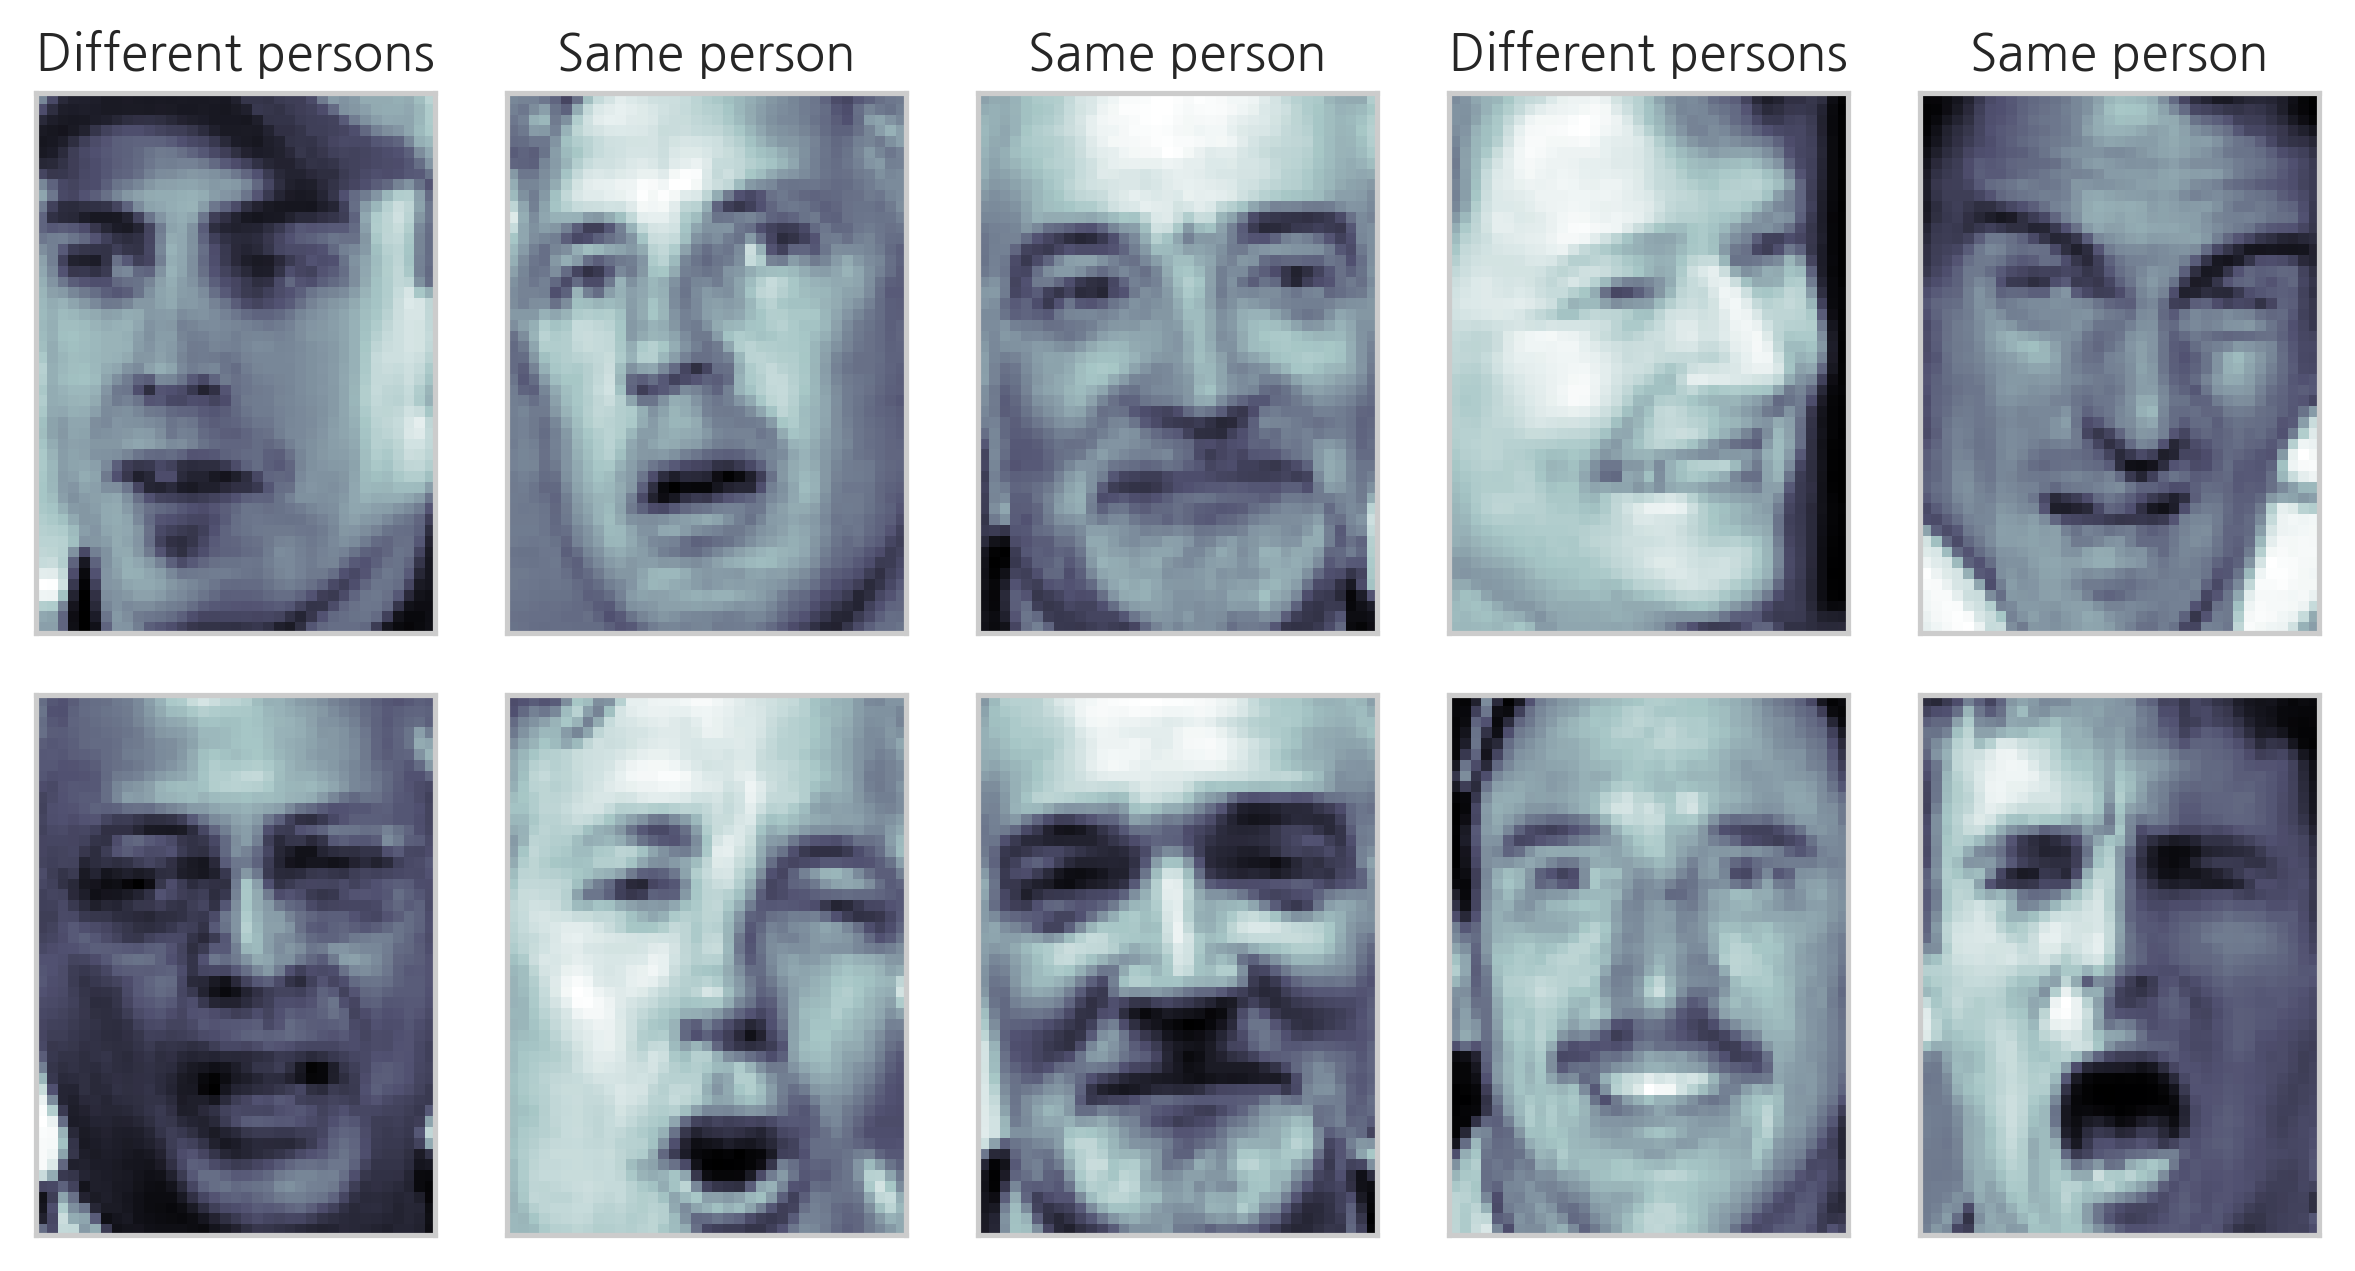

In [29]:
np.random.seed(0)
N = 2
M = 5
fig = plt.figure(figsize=(8, 5))
plt.subplots_adjust(top=1, bottom=0, hspace=0.01, wspace=0.05)
klist = np.random.choice(range(len(lfw_pairs.data)), M)
for j in range(M):
    k = klist[j]
    ax1 = fig.add_subplot(N, M, j+1)
    ax1.imshow(lfw_pairs.pairs[k][0], cmap=plt.cm.bone)
    ax1.grid(False)
    ax1.xaxis.set_ticks([])
    ax1.yaxis.set_ticks([])
    plt.title(lfw_pairs.target_names[lfw_pairs.target[k]])
    ax2 = fig.add_subplot(N, M, j+1 + M)
    ax2.imshow(lfw_pairs.pairs[k][1], cmap=plt.cm.bone)
    ax2.grid(False)
    ax2.xaxis.set_ticks([])
    ax2.yaxis.set_ticks([])
plt.tight_layout()
plt.show()